In [1]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

In [2]:
experiment       = 'lucas6x3'
abduction        = True
coeff_estimation = False

# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

# Load ground truth abstraction
Tau = mut.load_T(experiment)

In [3]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
l        = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
h        = len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

In [4]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

In [5]:
if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

Experiment with different pertubations; i.e. different noise distributions

In [6]:
ll_loc = params.loc[experiment][0]
ll_scale = params.scale[experiment][0]
hl_loc = params.loc[experiment][1]
hl_scale = params.scale[experiment][1]
lenv = ops.MultivariateLaplace(ll_loc, ll_scale)
henv = ops.MultivariateLaplace(hl_loc, hl_scale)

U_ll_hat = lenv.sample(num_llsamples)
U_hl_hat = henv.sample(num_hlsamples)

In [7]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [8]:
def run_empirical_optimization(U_L, U_H, L_models, H_models, epsilon, delta, eta_min, eta_max,
                                num_steps_min, num_steps_max, max_iter, tol, seed, robust_L, robust_H, initialization):
    
    torch.manual_seed(seed)
    erica = robust_L or robust_H
    # Convert inputs to torch tensors
    U_L = torch.as_tensor(U_L, dtype=torch.float32)
    U_H = torch.as_tensor(U_H, dtype=torch.float32)
    
    # Get dimensions
    N, l = U_L.shape
    _, h = U_H.shape
    
    # Initialize variables
    T     = torch.randn(h, l, requires_grad=True)
    if initialization == 'random':
        Theta = torch.randn(N, l, requires_grad=True)
        Phi   = torch.randn(N, h, requires_grad=True)

    elif initialization == 'projected':
        Theta = oput.init_in_frobenius_ball((N, l), epsilon)
        Phi   = oput.init_in_frobenius_ball((N, h), delta)

    
    # Create optimizers
    optimizer_T   = torch.optim.Adam([T], lr=eta_min)
    optimizer_max = torch.optim.Adam([Theta, Phi], lr=eta_max)
    
    prev_T_objective = float('inf')
    
    for iteration in tqdm(range(max_iter)):
         
        objs_T, objs_max = [], []
        # Step 1: Minimize with respect to T
        for _ in range(num_steps_min):
            optimizer_T.zero_grad()
            T_objective = oput.empirical_objective(U_L, U_H, T, Theta, Phi, L_models, H_models, Ill, omega)
            objs_T.append(T_objective.item())
            T_objective.backward()
            optimizer_T.step()
        #plot_progress(objs_T, 'T')
        # Step 2: Maximize with respect to Theta and Phi
        if erica == True:
            for _ in range(num_steps_max):
                optimizer_max.zero_grad()
                max_objective = -oput.empirical_objective(U_L, U_H, T, Theta, Phi, L_models, H_models, Ill, omega)
                max_objective.backward()
                optimizer_max.step()
                
                # Project onto constraint sets
                with torch.no_grad():
                    Theta.data = oput.project_onto_frobenius_ball(Theta, epsilon)
                    Phi.data   = oput.project_onto_frobenius_ball(Phi, delta)

                mobj = oput.empirical_objective(U_L, U_H, T, Theta, Phi, L_models, H_models, Ill, omega)
                objs_max.append(mobj.item())

        #plot_progress(objs_max, 'max')
        # Check convergence of T's objective
        with torch.no_grad():
            current_T_objective = T_objective.item()
            if abs(prev_T_objective - current_T_objective) < tol:
                print(f"Converged at iteration {iteration + 1}")
                break
            prev_T_objective = current_T_objective
            
            # if iteration % 10 == 0:
            #     print(f"Iteration {iteration}, T Objective: {current_T_objective}")
    
    return T.detach().numpy(), Theta.detach().numpy(), Phi.detach().numpy()

In [20]:
epsilon, delta = 2,2 #3, 3 WORKS! BUT WHY?

eta_max = 0.01
eta_min = 0.001

max_iter = 1000
num_steps_min = 5
num_steps_max = 5

robust_L = True 
robust_H = True

initialization = 'random'

tol = 1e-4

seed = 23

In [21]:
params_erica = {
                'U_L': U_ll_hat,
                'U_H': U_hl_hat,
                'L_models': LLmodels,
                'H_models': HLmodels,
                'epsilon': epsilon,
                'delta': delta,
                'eta_min': eta_min,
                'eta_max': eta_max,
                'num_steps_min': num_steps_min,
                'num_steps_max': num_steps_max,
                'max_iter': max_iter,
                'tol': tol,
                'seed': seed,
                'robust_L': robust_L,
                'robust_H': robust_H,
                'initialization': initialization
            }

## 2. ERiCA optimization

In [22]:
T_erica, Theta_erica, Phi_erica = run_empirical_optimization(**params_erica)

 39%|███▉      | 392/1000 [04:54<07:36,  1.33it/s]

Converged at iteration 393


In [23]:
empirical_boundary_params = {'Theta': (Theta_erica, epsilon), 'Phi': (Phi_erica, delta)}


joblib.dump(empirical_boundary_params, f"data/{experiment}/empirical_boundary_params.pkl")

['data/lucas6x3/empirical_boundary_params.pkl']

## 2. ENRiCO optimization

In [24]:

T_enrico, Theta_enrico, Phi_enrico = run_empirical_optimization(**{**params_erica, 'robust_L': False, 'robust_H': False})

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 842/1000 [04:23<00:49,  3.19it/s]

Converged at iteration 843


## Save the results

In [25]:
joblib.dump(T_erica, f"data/{experiment}/T_erica.pkl")
joblib.dump(T_enrico, f"data/{experiment}/T_enrico.pkl")
joblib.dump(Tau, f"data/{experiment}/Tau.pkl")

['data/lucas6x3/Tau.pkl']

# Evaluation

### Condition number comparison

{'T_erica': 4.2446113, 'T_enrico': 23.722145, 'Tau': 3.752295770783741}


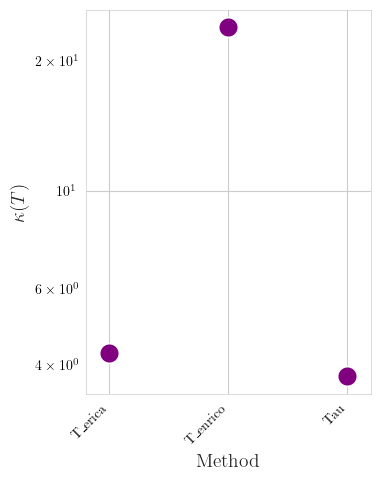

In [26]:
methods      = ['T_erica', 'T_enrico', 'Tau']
condition_nums = {name: evut.condition_number(T) for name, T in zip(methods, [T_erica, T_enrico, Tau])}
print(condition_nums)
evut.plot_condition_nums(condition_nums)

### Abstraction error comparison

In [27]:
data = mut.load_samples(experiment)

In [28]:
add_pertL          = True
add_pertH          = True
pert_typeL         = 'constraint_set'
pert_typeH         = 'constraint_set'

lin_contaminationL = False
lin_contaminationH = False
cont_type          = 'huber'
cont_fracL         = .9
cont_fracH         = .6

metric             = 'fro'
num_iter           = 10 

random_normal random_normal


100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Average e(τ) for T_erica: 3253.441 ± 0.364

Average e(τ) for T_enrico: 3289.953 ± 0.405

Average e(τ) for Tau: 4511.257 ± 1.207



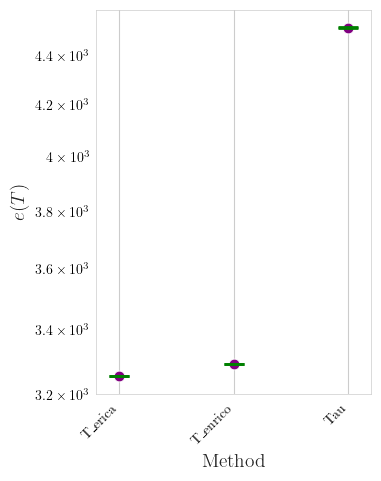


random_normal random_uniform


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Average e(τ) for T_erica: 3260.568 ± 0.281

Average e(τ) for T_enrico: 3291.169 ± 0.318

Average e(τ) for Tau: 4456.096 ± 1.392



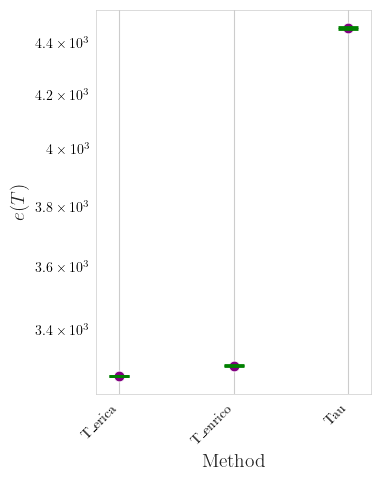


random_normal constraint_set


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Average e(τ) for T_erica: 3229.015 ± 17.320

Average e(τ) for T_enrico: 3265.856 ± 17.002

Average e(τ) for Tau: 4492.432 ± 12.988



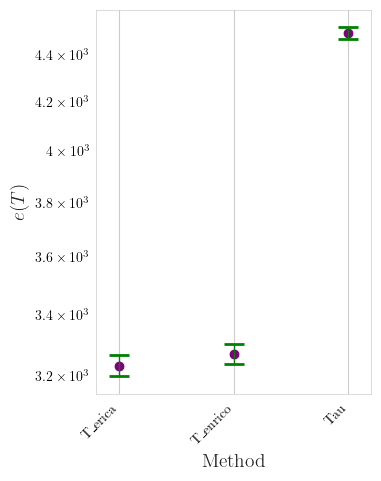


random_normal boundary


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Average e(τ) for T_erica: 3328.105 ± 0.283

Average e(τ) for T_enrico: 3354.347 ± 0.373

Average e(τ) for Tau: 4474.917 ± 2.054



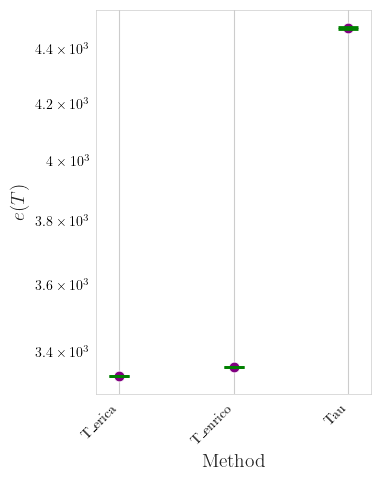


random_uniform random_normal


100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


Average e(τ) for T_erica: 3235.059 ± 0.361

Average e(τ) for T_enrico: 3247.132 ± 0.338

Average e(τ) for Tau: 4792.684 ± 0.791



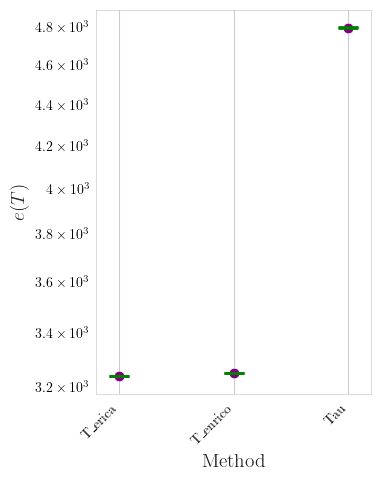


random_uniform random_uniform


100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Average e(τ) for T_erica: 3240.284 ± 0.127

Average e(τ) for T_enrico: 3237.560 ± 0.117

Average e(τ) for Tau: 4631.455 ± 0.592



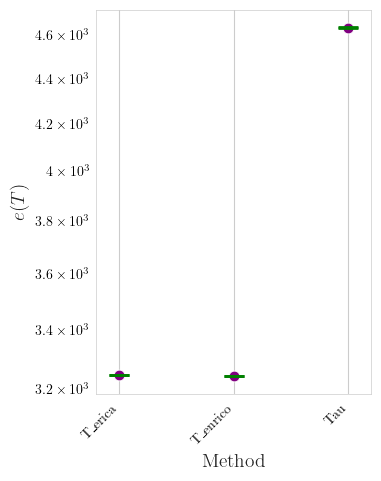


random_uniform constraint_set


100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


Average e(τ) for T_erica: 3216.580 ± 20.021

Average e(τ) for T_enrico: 3228.715 ± 19.905

Average e(τ) for Tau: 4779.151 ± 14.237



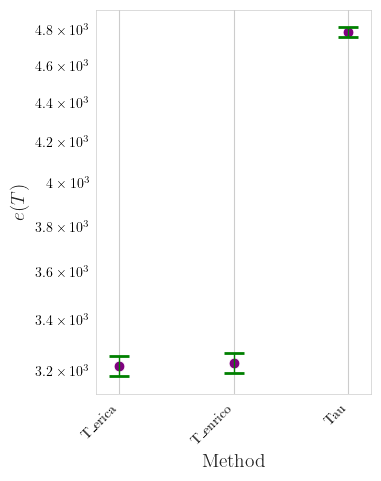


random_uniform boundary


100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


Average e(τ) for T_erica: 3307.613 ± 0.081

Average e(τ) for T_enrico: 3296.025 ± 0.123

Average e(τ) for Tau: 4585.356 ± 0.682



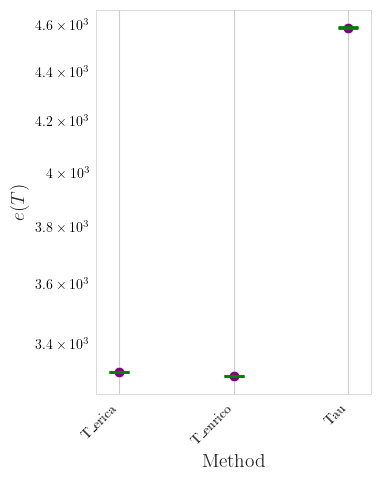


constraint_set random_normal


100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


Average e(τ) for T_erica: 3241.672 ± 3.324

Average e(τ) for T_enrico: 3267.033 ± 6.661

Average e(τ) for Tau: 4292.671 ± 67.920



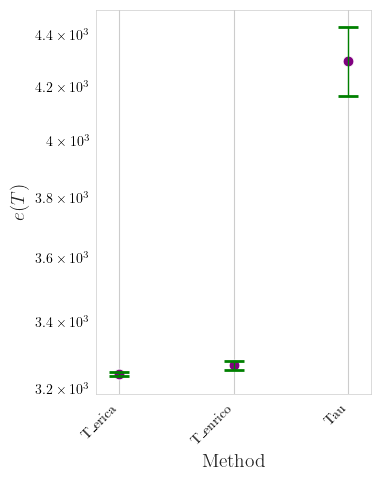


constraint_set random_uniform


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


Average e(τ) for T_erica: 3247.287 ± 2.563

Average e(τ) for T_enrico: 3264.720 ± 5.160

Average e(τ) for Tau: 4190.487 ± 56.729



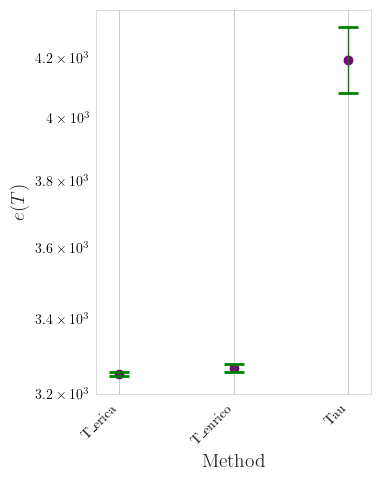


constraint_set constraint_set


100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


Average e(τ) for T_erica: 3210.168 ± 15.724

Average e(τ) for T_enrico: 3233.972 ± 15.292

Average e(τ) for Tau: 4227.309 ± 31.039



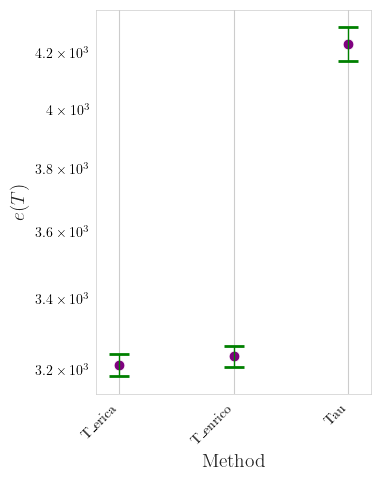


constraint_set boundary


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Average e(τ) for T_erica: 3314.311 ± 2.506

Average e(τ) for T_enrico: 3326.858 ± 5.004

Average e(τ) for Tau: 4196.530 ± 53.486



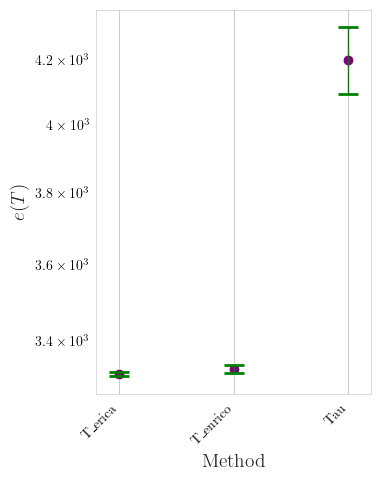


boundary random_normal


100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


Average e(τ) for T_erica: 3323.213 ± 0.303

Average e(τ) for T_enrico: 3408.883 ± 0.337

Average e(τ) for Tau: 4287.872 ± 0.443



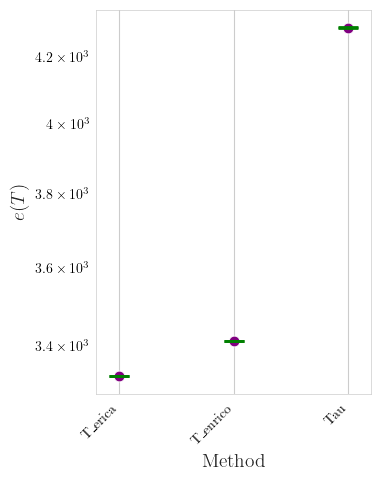


boundary random_uniform


100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


Average e(τ) for T_erica: 3359.922 ± 0.094

Average e(τ) for T_enrico: 3456.207 ± 0.097

Average e(τ) for Tau: 4220.845 ± 0.054



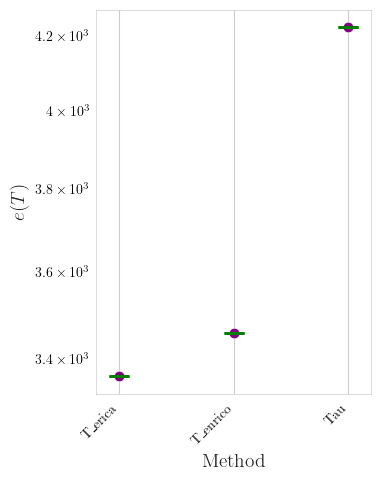


boundary constraint_set


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Average e(τ) for T_erica: 3292.405 ± 12.671

Average e(τ) for T_enrico: 3378.895 ± 12.295

Average e(τ) for Tau: 4259.970 ± 11.754



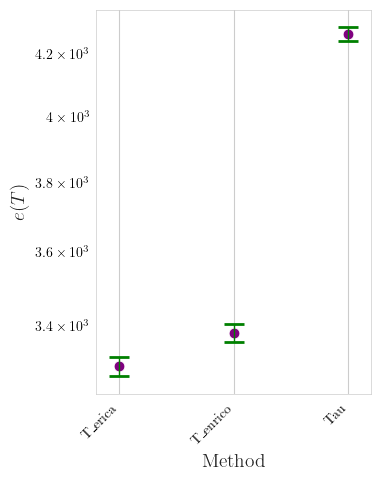


boundary boundary


100%|██████████| 10/10 [00:01<00:00,  7.19it/s]


Average e(τ) for T_erica: 3476.064 ± 0.000

Average e(τ) for T_enrico: 3590.626 ± 0.000

Average e(τ) for Tau: 4245.468 ± 0.000



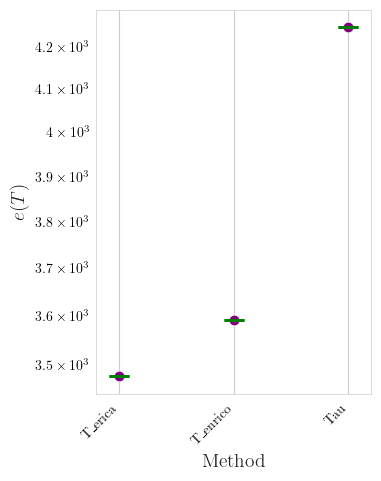

In [29]:
for (pert_typeL, pert_typeH) in product(['random_normal', 'random_uniform', 'constraint_set', 'boundary'], ['random_normal', 'random_uniform', 'constraint_set', 'boundary']):
    print(pert_typeL, pert_typeH)
    methods           = ['T_erica', 'T_enrico', 'Tau']
    abstraction_error = {name: [] for name in methods}
    # Outer loop: number of noise sampling iterations
    for iter_num in tqdm(range(num_iter)): # desc="Noise sampling iterations"

        pert_L = evut.generate_pertubation(data[None][0], pert_typeL, 'Theta', experiment)
        pert_H = evut.generate_pertubation(data[None][1], pert_typeH, 'Phi', experiment)
        
        # For this noise iteration, evaluate each method
        for i, method in enumerate(methods):
            T     = mut.load_abstraction(experiment, method)
            total = 0
            # Compute average error over Ill for this method
            for iota in Ill:
                # Get base data and add noise
                base, abst = data[iota]
                
                if add_pertL:
                    base = base + pert_L 
                if add_pertH:
                    abst = abst + pert_H 
                    
                if lin_contaminationL:
                    base  = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
                if lin_contaminationH:
                    abst  = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
                    
                base_norm = base / np.linalg.norm(base, 'fro')
                abst_norm = abst / np.linalg.norm(abst, 'fro')
                # Apply method and compute distance
                tau_base = base @ T.T

                dist = evut.compute_empirical_distance(tau_base, abst, metric)
                    
                total   += dist
                
            iter_avg = total / len(Ill)
            abstraction_error[methods[i]].append(iter_avg)
        
        final_abstraction_error = {}
    for name in methods:
        mean_e = np.mean(abstraction_error[name])
        std_e = np.std(abstraction_error[name])
        final_abstraction_error[name] = (mean_e, std_e * 1.96)
        print(f"Average e(τ) for {name}: {mean_e:.3f} ± {std_e:.3f}\n")

    evut.plot_abstraction_error(final_abstraction_error)
    print( )

In [30]:
print('finished')

finished


In [75]:
# Define specific parameter combinations to test
param_combinations = [
                        {'eta_min': 0.001},
                        {'eta_min': 0.0001}
                     ]

# Store results
results = []

# Run grid search
for params in tqdm(param_combinations):
    print(f"\nTesting parameters: {params}")
    
    # Update params_erica with current parameter combination
    current_params = {
        'U_L': U_ll_hat,
        'U_H': U_hl_hat,
        'L_models': LLmodels,
        'H_models': HLmodels,
        'epsilon': 4,
        'delta': 4,
        'eta_max': 0.001,
        'max_iter': 1000,
        'num_steps_min': 4,
        'num_steps_max': 3,
        'tol': 1e-4,
        'seed': seed,
        'robust_L': True,
        'robust_H': True,
        'initialization': 'random',
        **params  # Add the current parameter combination
    }
    
    # Run ericaoptimization
    T_erica, Theta_erica, Phi_erica = run_empirical_optimization(**current_params)
    
    
    # Run enrico optimization
    # Evaluate current parameters
    abstraction_error = []
    for _ in range(num_iter):
       
        pert_L = evut.generate_pertubation(data[None][0], 'random_normal', 'Theta', experiment)
        pert_H = evut.generate_pertubation(data[None][1], 'random_normal', 'Phi', experiment)
        
        total = 0
        for iota in Ill:
            base, abst = data[iota]
            
            if add_pertL:
                base = base + pert_L 
            if add_pertH:
                abst = abst + pert_H 
                
            base_norm = base / np.linalg.norm(base, 'fro')
            abst_norm = abst / np.linalg.norm(abst, 'fro')
            # Apply method and compute distance
            tau_base = base @ T.T

            dist = evut.compute_empirical_distance(tau_base, abst, metric)
                
            total   += dist
                        
        iter_avg = total / len(Ill)
        abstraction_error.append(iter_avg)
    
    mean_error = np.mean(abstraction_error)
    std_error = np.std(abstraction_error)
    
    # Store results
    results.append({
        'parameters': params,
        'mean_error': mean_error,
        'std_error': std_error,
        'condition_number': evut.condition_number(T_erica)
    })
    print(f"Mean error: {mean_error:.4f} ± {std_error*1.96:.4f}")

# Find best parameters
best_result = min(results, key=lambda x: x['mean_error'])
print("\nBest parameters:")
print(f"Parameters: {best_result['parameters']}")
print(f"Mean error: {best_result['mean_error']:.4f} ± {best_result['std_error']*1.96:.4f}")
print(f"Condition number: {best_result['condition_number']:.4f}")

# # Optional: Save results to file
# import json
# with open(f"data/{experiment}/grid_search_results.json", 'w') as f:
#     json.dump(results, f, indent=2)

  0%|          | 0/2 [00:00<?, ?it/s]


Testing parameters: {'eta_min': 0.001}


 50%|█████     | 1/2 [02:03<02:03, 123.57s/it]

Mean error: 1110.0787 ± 3.2506

Testing parameters: {'eta_min': 0.0001}


100%|██████████| 2/2 [04:09<00:00, 124.72s/it]

Mean error: 1109.9167 ± 2.8850

Best parameters:
Parameters: {'eta_min': 0.0001}
Mean error: 1109.9167 ± 2.8850
Condition number: 1.4791
